## Week 9 - Session 1: MDP with PCA

- Understand three types of feature selection methods: Filtered, Wrapper, and Embedded Approach
- Understand PCA as a feature selection method (advantages and limitations) 
- Understand how to compare two different feature selection approaches (PCA vs. Random Feature Selection) with an MDP framework in terms of effectiveness and efficiency

In [1]:
import numpy as np
import pandas as pd
import mdptoolbox, mdptoolbox.example
import argparse
import math
from MDP_policy import *
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
import random 
import warnings
warnings.filterwarnings('ignore')

## MDP with PCA feature selection
### 1.1. Load Data and Preprocessing

In [2]:
# Load data
org_data = pd.read_csv('./MDP_dataset.csv')

# define different feature sets: feature_space(total), static_feats, candidate_feats
feature_space = list(org_data.columns.values)
static_feats, candidate_feats = feature_space[:6], feature_space[6:]

print("# static features: {}".format(len(static_feats)))
print("# candidate features: {}\n".format(len(candidate_feats)))

org_data.head(3)

# static features: 6
# candidate features: 124



,student,currProb,course,session,priorTutorAction,reward,Interaction,hintCount,TotalTime,TotalPSTime,...,cumul_NextStepClickCountWE,cumul_PreviousStepClickCountWE,cumul_deletedApp,CurrPro_NumProbRule,CurrPro_avgProbTime,CurrPro_avgProbTimePS,CurrPro_avgProbTimeDeviationPS,CurrPro_avgProbTimeWE,CurrPro_avgProbTimeDeviationWE,CurrPro_medianProbTime
0,0006-F14,1.0.1.0,226-001-BARNES-F14,1,PS,0.0,47,0,535.244,535.244,...,0,0,0,3,472.529142,402.247660,754.222657,48.043621,85.893332,226.8775
1,0006-F14,1.0.2.0,226-001-BARNES-F14,1,WE,0.0,12,0,56.759,0.000,...,5,0,0,3,167.952813,136.653564,325.619923,25.727113,44.427446,81.4950
2,0006-F14,1.0.3.0,226-001-BARNES-F14,1,WE,0.0,6,0,6.695,0.000,...,10,0,0,4,572.535163,522.227282,1017.360329,23.751811,45.742236,124.3650


### 2.2. Feature Selection with PCA + MDP training (Value Iteration)
 - Set the same number of bins to the random feature selecction for the comparison
 - Explore different number of bins and compare the results of two approaches (random feature selection and PCA) to examine the robustness of each approach.  

In [3]:
%%time
x = []
y = []
data_sets = {}
candidate_data = org_data[candidate_feats]

n_bins = 7
for k in range(1, 9):
    steps = [
             ('standardize', StandardScaler()),
             ('pca', PCA(k)),
             ('discretize', KBinsDiscretizer(n_bins=n_bins, encode='ordinal'))
            ]
    
    model = Pipeline(steps=steps)

    data = model.fit_transform(candidate_data)
    
    col_names = ['f{}'.format(n) for n in range(1, k+1)]
    new_data = pd.DataFrame(data=data, columns=col_names)
    
    sample_data = pd.concat([org_data[static_feats], new_data], axis=1)
    sample_feats = list(sample_data.columns.values)
    data_sets[k] = sample_data
    
    # load data set with selected or extracted discrete features
    [start_states, A, expectR, distinct_acts, distinct_states] = generate_MDP_input(sample_data, sample_feats)
    
    # apply Value Iteration to run the MDP
    try:
        vi = mdptoolbox.mdp.ValueIteration(A, expectR, discount = 0.9)
        vi.run()

        # ----------------------------------------------
        # evaluate policy using ECR
        ecr = calcuate_ECR(start_states, vi.V)
        print("{} Features - ECR {}".format(k, ecr))
        
        x.append(k)
        y.append(ecr)
        
    except OverflowError:
        error_feats.append(feat)
        print("Error occured!")
        pass

1 Features - ECR 12.810527402883773
2 Features - ECR 22.790510636831492
3 Features - ECR 36.36652711360276
4 Features - ECR 53.167874398818356
5 Features - ECR 47.03157422922148
6 Features - ECR 43.196515374003646
7 Features - ECR 36.65051438754068
8 Features - ECR 35.798842355619726
CPU times: user 2min 1s, sys: 6.88 s, total: 2min 8s
Wall time: 28.1 s


### 2.4. Results

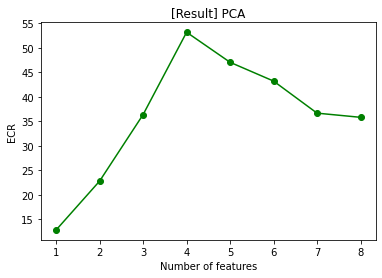

In [4]:
import matplotlib.pyplot as plt

plt.plot(x, y, 'go-')
# plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^')
plt.title('[Result] PCA')
plt.xlabel('Number of features')
plt.ylabel('ECR')
plt.show()

### 2.5. Value Iteration with the best feature set (PCA)

In [7]:
%%time
# feature counts with the highest ECR.
best_k = y.index(max(y))+1
print("Best k (number of features): {}".format(best_k))

sample_data = data_sets[best_k]
sample_feats = list(sample_data.columns.values)

# load data set with selected or extracted discrete features
[start_states, A, expectR, distinct_acts, distinct_states] = generate_MDP_input(sample_data, sample_feats)

# apply Value Iteration to run the MDP
try:
    vi = mdptoolbox.mdp.ValueIteration(A, expectR, discount = 0.9)
    vi.run()
    
    # output policy
    output_policy(distinct_acts, distinct_states, vi)

except OverflowError:
    print("Error occured!\n")
    pass

n_states = n_bins

for i in range(1, best_k):
    n_states *= n_bins
    
print("\nTotal number of states: {}".format(n_states))

Best k (number of features): 4
Policy: 
state -> action, value-function
3.0:2.0:0.0:5.0:3.0:2.0:0.0:5.0 -> WE, 44.51389553324064
5.0:0.0:3.0:3.0:5.0:0.0:3.0:3.0 -> WE, 31.899991760355295
2.0:4.0:2.0:3.0:2.0:4.0:2.0:3.0 -> WE, 34.37389747678689
4.0:4.0:3.0:0.0:4.0:4.0:3.0:0.0 -> PS, 52.48229304093762
1.0:5.0:0.0:2.0:1.0:5.0:0.0:2.0 -> WE, 37.891026117626176
1.0:0.0:5.0:4.0:1.0:0.0:5.0:4.0 -> PS, 20.91700342375595
2.0:2.0:5.0:0.0:2.0:2.0:5.0:0.0 -> PS, 55.086767262830676
3.0:0.0:5.0:3.0:3.0:0.0:5.0:3.0 -> PS, 27.3477807740141
2.0:1.0:2.0:2.0:2.0:1.0:2.0:2.0 -> PS, 34.535442697272465
6.0:6.0:4.0:2.0:6.0:6.0:4.0:2.0 -> PS, 40.49479500190034
0.0:2.0:3.0:6.0:0.0:2.0:3.0:6.0 -> PS, 3.681344888278439
6.0:2.0:5.0:1.0:6.0:2.0:5.0:1.0 -> WE, 38.34034192603453
0.0:3.0:6.0:6.0:0.0:3.0:6.0:6.0 -> PS, 70.26179298423894
1.0:4.0:4.0:3.0:1.0:4.0:4.0:3.0 -> PS, 77.90735453497585
2.0:2.0:5.0:4.0:2.0:2.0:5.0:4.0 -> PS, 77.09646741854291
4.0:6.0:1.0:0.0:4.0:6.0:1.0:0.0 -> WE, 56.28401950818199
5.0:5.0:1.0:2

## MDP with Random Feature Selection 

### 1. Load data and preprocession

In [8]:
# Load data
org_data = pd.read_csv('MDP_dataset.csv')

# Define different feature sets: feature_space(total), static_feats, candidate_feats
feature_space = list(org_data.columns.values)
static_feats, candidate_feats = feature_space[:6], feature_space[6:]

# Report the number of features.
print("# static features: {}".format(len(static_feats)))
print("# candidate features: {}\n".format(len(candidate_feats)))


# Extract continuous features for discretization
#  - we consider features with more than 6 distinct values continous, except for the 'object' type features.

# > get column names, types, # of unique values
col_names = list(org_data.columns.values)
col_types = list(org_data.dtypes.astype('str'))

col_numval = []
for col in col_names:
    numval = len(org_data[col].unique())
    col_numval.append(numval)

# > generate a dataframe for extraction
col_dict = {'name': col_names, 'type': col_types, 'uniqueval': col_numval}
col_data = pd.DataFrame(col_dict, columns=['name', 'type', 'uniqueval'])

# > extract features which satisfy the condition

# static features: 6
# candidate features: 124



### 2. 2. Discretization with Random Feature Selection + MDP training (Value Iteration)
 - Set the same number of bins to the PCA for the comparison

In [9]:
%%time
## Number of bins for discretization
n_bins = 7   

condition = (col_data['uniqueval'] > n_bins)
continuous_feats = col_data[condition].name.tolist()
continuous_feats = [i for i in continuous_feats if i not in static_feats]

# > print the number of selected features
print("# continuous features: {}".format(len(continuous_feats)))

# Discretize the continuous features 
from sklearn.preprocessing import KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=n_bins, encode='ordinal')#, strategy='uniform')

new_data = org_data.copy()

# for col in continuous_feats:
for col in candidate_feats:
    data_reshaped = np.reshape(np.array(org_data[col]), (-1, 1))
    new_data[col] = enc.fit_transform(data_reshaped)


## Random feature selection
x = []
y = []
feature_sets = {}
can_size = len(candidate_feats)


for k in range(1, 9):
    print("{} selected:".format(k), end=" ")
    # random select k features from the candidate feature set.
    chosen_feats = random.sample(candidate_feats, k)
    # store the chosen feature set in a dictionary
    feature_sets[k] = chosen_feats
    print(chosen_feats, end=" ")
    
    sample_feats = static_feats + chosen_feats
    sample_data = new_data[sample_feats]
    
    # load data set with selected or extracted discrete features
    [start_states, A, expectR, distinct_acts, distinct_states] = generate_MDP_input(sample_data, sample_feats)
    
    # apply Value Iteration to run the MDP
    try:
        vi = mdptoolbox.mdp.ValueIteration(A, expectR, discount = 0.9)
        vi.run()

        # evaluate policy using ECR
        ecr = calcuate_ECR(start_states, vi.V)
        print("-> ECR: {}\n".format(ecr))
        
        x.append(k)
        y.append(ecr)
        
    except OverflowError:
        print("Error occured!\n")
        pass

# continuous features: 100
1 selected: ['cumul_difficultProblemCountSolved'] -> ECR: 2.0994241334154715

2 selected: ['cumul_probIndexinLevel', 'AppCount'] -> ECR: 21.131027950833385

3 selected: ['CurrPro_avgProbTimeDeviationWE', 'TotalWETime', 'cumul_probAlternate'] -> ECR: 15.793887327634575

4 selected: ['cumul_DirectProofActionCount', 'NewLevel', 'ruleScoreHS', 'CurrPro_NumProbRule'] -> ECR: 25.798731435370076

5 selected: ['cumul_NonPSelements', 'ruleScoreCONTRA', 'easyProbAlternate', 'InDirectProofActionCount', 'cumul_SystemInfoHintCount'] -> ECR: 18.716408502374925

6 selected: ['cumul_WrongSemanticsApp', 'probDiff', 'ruleScoreDIST', 'cumul_SystemInfoHintCount', 'ruleScoreCOM', 'cumul_TotalPSTime'] -> ECR: 37.86086883435718

7 selected: ['cumul_F1Score', 'NonPSelements', 'probAlternate', 'InDirectProofActionCount', 'cumul_HoverHintCount', 'PrightAppRatio', 'cumul_BlankRatio'] -> ECR: 38.8684419857715

8 selected: ['SolvedPSInLevel', 'cumul_HoverHintCount', 'CurrPro_avgProbTimeD

### 2.4 Results

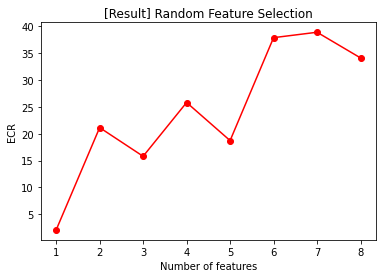

In [10]:
plt.plot(x, y, 'ro-')
plt.title('[Result] Random Feature Selection')
plt.xlabel('Number of features')
plt.ylabel('ECR')
plt.show()

### 2.5. Value Iteration with the best feature set (random feature selection)

In [11]:
%%time
# feature counts with the highest ECR.

best_k = y.index(max(y))+1
print("Best k (number of features): {}".format(best_k))
sample_data = data_sets[best_k]
sample_feats = list(sample_data.columns.values)

# load data set with selected or extracted discrete features
[start_states, A, expectR, distinct_acts, distinct_states] = generate_MDP_input(sample_data, sample_feats)

# apply Value Iteration to run the MDP
try:
    vi = mdptoolbox.mdp.ValueIteration(A, expectR, discount = 0.9)
    vi.run()
    
    # output policy
    output_policy(distinct_acts, distinct_states, vi)

except OverflowError:
    print("Error occured!\n")
    pass

n_states = n_bins

for i in range(1, best_k):
    n_states *= n_bins
    
print("\nTotal number of states: {}".format(n_states))

Best k (number of features): 7
Policy: 
state -> action, value-function
4.0:6.0:2.0:1.0:4.0:1.0:5.0:4.0:6.0:2.0:1.0:4.0:1.0:5.0 -> WE, 109.06242571256028
2.0:3.0:0.0:2.0:0.0:2.0:1.0:2.0:3.0:0.0:2.0:0.0:2.0:1.0 -> WE, 156.54953271028023
5.0:5.0:1.0:4.0:2.0:3.0:0.0:5.0:5.0:1.0:4.0:2.0:3.0:0.0 -> WE, 55.899197363956
5.0:3.0:3.0:5.0:6.0:0.0:3.0:5.0:3.0:3.0:5.0:6.0:0.0:3.0 -> PS, 29.21489172972974
6.0:0.0:6.0:3.0:1.0:0.0:0.0:6.0:0.0:6.0:3.0:1.0:0.0:0.0 -> PS, 8.92791795819159
0.0:3.0:6.0:5.0:0.0:6.0:4.0:0.0:3.0:6.0:5.0:0.0:6.0:4.0 -> WE, 0.0
5.0:1.0:1.0:2.0:4.0:4.0:4.0:5.0:1.0:1.0:2.0:4.0:4.0:4.0 -> PS, 0.0
6.0:0.0:3.0:3.0:4.0:6.0:0.0:6.0:0.0:3.0:3.0:4.0:6.0:0.0 -> PS, 43.971428571428504
2.0:4.0:1.0:1.0:3.0:3.0:5.0:2.0:4.0:1.0:1.0:3.0:3.0:5.0 -> PS, 33.27257500588815
6.0:6.0:1.0:2.0:0.0:5.0:0.0:6.0:6.0:1.0:2.0:0.0:5.0:0.0 -> PS, 0.0
3.0:6.0:3.0:0.0:5.0:1.0:6.0:3.0:6.0:3.0:0.0:5.0:1.0:6.0 -> WE, 69.91136134103259
1.0:4.0:6.0:1.0:0.0:6.0:5.0:1.0:4.0:6.0:1.0:0.0:6.0:5.0 -> PS, 0.0
4.0:0.0:3.0:

### Report
- Report the description of PCA and any observations from the experiments.
    * What is the advantages and limitations of PCA?
- Report the final feature set and the correponding ECR value, and compare it to the best ECR with the random feature selection. 
    * How to measure the effectiveness and the efficiency of feature selection / policy? 
    * In this MDP example, which feature selection method is more effective and efficient based on the measurements above? 
- Report your final policy and the number of PS/WE actions. Include a brief description of the policy.

### Discussion
 - Among Filtered, Wrapper, and Embedded approaches, what type of feature selection is this?
 - The advatages/ disadvatages of each type of feature selection methods in an MDP framework?